# OMORI One Wing Jash win chance
## Summary
* Probability of winning against "One Wing Jash" is ~13.4%
* Num tries to have at least 90% chance of winning is ~16

![plot.png](plot.png)

## Breakdown
Here are the details of the simulations and calculations I did to determine the results above.

### Win chance
Since I'm a software developer by trade I decided to simulate the game rather than do the proper math out...

Doing a random simulation of the game over and over again (counting the wins and losses) will allow us to estimate the chance of winning the game on a single try. The more times we run the simulation (iterations), the more accurate our estimate of the win chance will be.

Luckily "One Wing Jash" randomly chooses which move to use (rock, paper, scissors) so no matter which move we choose as the player, we always have a 1/3rd chance of hitting, 1/3rd chance of drawing, and 1/3rd chance of being hit.

Either us, the player, or the enemy hitting multiple times in a row increases the combo meter and will cause their next uninterrupted hit to do more damage.

In [1]:
def simulate(player_health, enemy_health):
    combo = 1
    hit_last = None

    while True:
        if player_health <= 0:
            return 0
        elif enemy_health <= 0:
            return 1

        result = random.randrange(3)
        assert result in [0, 1, 2]

        if result == 0:
            # Draw
            combo = 1
            hit_last = None
        elif result == 1:
            # Player hits
            if hit_last == "enemy":
                combo = 1
                
            enemy_health -= combo
            combo += 1

            hit_last = "player"
        elif result == 2:
            # Enemy hits
            if hit_last == "player":
                combo = 1
                
            player_health -= combo
            combo += 1

            hit_last = "enemy"

For now we can run the simulation 10 million times. This should get us pretty close to the exact probability.

In [2]:
import random
import pandas as pd

# Make sure our "random" results are reproduceable
random.seed(42)

num_iterations = 10000000 # 10 million iterations

data = []
win_count = 0
for i in range(0, num_iterations):
    win_count += simulate(3, 9)

    iterations = i + 1

    # Record the results after every 1000 iterations so we can make a plot to see how the win
    # chance estimate changes as we do more iterations
    if iterations % 1000 == 0:
        win_percentage = win_count / float(iterations) * 100.0
        data.append((iterations, win_count, win_percentage))

data = pd.DataFrame(data, columns=["iterations", "win_count", "win_percentage"])
data

,iterations,win_count,win_percentage
0,1000,127,12.700000
1,2000,248,12.400000
2,3000,383,12.766667
3,4000,502,12.550000
4,5000,632,12.640000
...,...,...,...
9995,9996000,1335522,13.360564
9996,9997000,1335651,13.360518
9997,9998000,1335798,13.360652
9998,9999000,1335918,13.360516


If we do a quick plot of the estimated win chance as we run more iterations of the simulation we can see that we converge to a particular win chance.

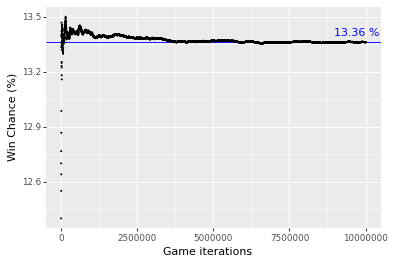

<ggplot: (8740643343613)>

In [3]:
from plotnine import *

ggplot(data, aes(x="iterations", y="win_percentage")) +\
    geom_hline(yintercept=13.36, color="blue") +\
    geom_point(size=0.1) +\
    geom_text(data[data["iterations"] == num_iterations], label="13.36 %", nudge_y=0.05, nudge_x=-300000, color="blue") +\
    xlab("Game iterations") +\
    ylab("Win Chance (%)")

In [4]:
win_percentage = list(data.iterrows())[-1][1]['win_percentage']

print(f"Chance of winning: ~{win_percentage}%")

Chance of winning: ~13.3604%


### How close is our estimate?
We calculated the win chance using a lot of simulated matches, so we should be really close to the exact chance, but how close are we?

To find this out we can use a Beta distribution. Modelling a Beta distribution will give us a plot where the x-axis represents possible win chances and the y-axis shows how likely that win chance is the true win chance (given the simulation results).

For more info on Beta distributions see:
* https://vitalflux.com/beta-distribution-explained-with-python-examples/
* https://en.wikipedia.org/wiki/Beta_distribution

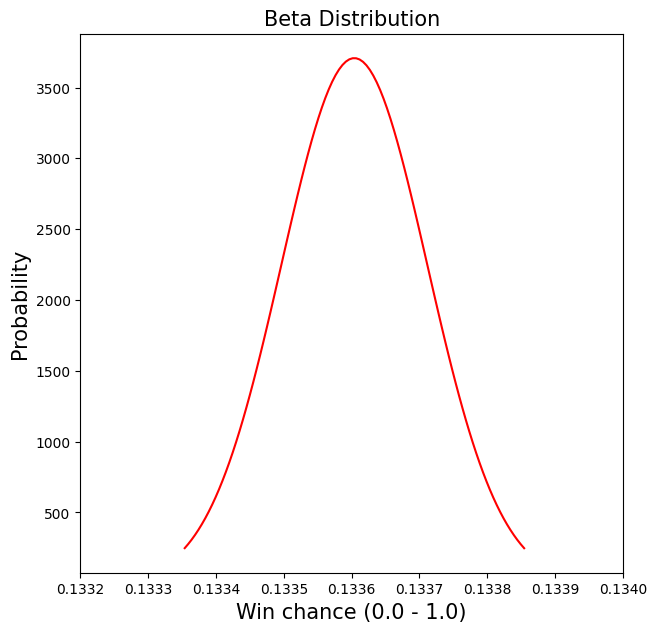

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

a, b = win_count, num_iterations - win_count

# Calculate the distribution (focusing on the 98% most likely values)
x = np.linspace(beta.ppf(0.01, a, b),beta.ppf(0.99, a, b), 100)

plt.figure(figsize=(7,7))
plt.xlim(0.1332, 0.1340)
plt.plot(x, beta.pdf(x, a, b), 'r-')
plt.title('Beta Distribution', fontsize='15')
plt.xlabel('Win chance (0.0 - 1.0)', fontsize='15')
plt.ylabel('Probability', fontsize='15')
plt.show()

Looking at this  plot we can see that the true probablility is almost certainly (98% chance) within the following value range:

In [6]:
print(round(beta.ppf(0.01, a, b), 5), "to", round(beta.ppf(0.99, a, b), 5))

0.13335 to 0.13385


### Number of tries to get at least 90 percent chance to win

In [7]:
win_probability = win_percentage / 100.0

def chance_of_at_least_one_success(p, num_tries):
    return 1.0 - ((1.0 - p) ** num_tries)

print(chance_of_at_least_one_success(0.5, 1))
print(chance_of_at_least_one_success(0.5, 2))
print(chance_of_at_least_one_success(0.5, 3))
print(chance_of_at_least_one_success(0.5, 4))

0.5
0.75
0.875
0.9375


In [8]:
data2 = [
    (num_tries, chance_of_at_least_one_success(win_probability, num_tries) * 100.0)
    for num_tries in range(0, 31)
]

data2 = pd.DataFrame(data2, columns=["num_tries", "at_least_one_win_percentage"])
data2

,num_tries,at_least_one_win_percentage
0,0,0.000000
1,1,13.360400
2,2,24.935797
3,3,34.964675
4,4,43.653654
5,5,51.181752
6,6,57.704065
7,7,63.354971
8,8,68.250893
9,9,72.492701


/home/chris/anaconda3/envs/omori_pet_rocks/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/chris/anaconda3/envs/omori_pet_rocks/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plot.png


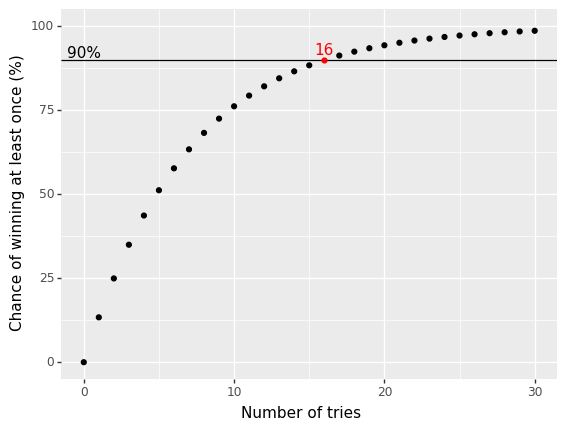

<ggplot: (8740640860743)>

In [9]:
import matplotlib.pyplot as plt

p = ggplot(data, aes(x="num_tries", y="at_least_one_win_percentage")) +\
    geom_point(data2[data2["num_tries"] != 16]) +\
    geom_hline(yintercept=90) +\
    geom_text(data2[data2["num_tries"] == 16], aes(label="num_tries"), nudge_y=3, color="red") +\
    geom_text(data2[data2["num_tries"] == 0], label="90%", nudge_y=92) +\
    geom_point(data2[data2["num_tries"] == 16], color="red") +\
    ylim(0.0, 100.0) +\
    xlab("Number of tries") +\
    ylab("Chance of winning at least once (%)")

ggsave(plot=p, filename='plot.png', dpi=100)
p

## Prior works
* [Hhhhhhhhhh7 on the OMORI Wiki](https://omori.fandom.com/wiki/Talk:PET_ROCKS) (December 2021)
    * The code for their calculation is available [here](https://pastebin.com/TZm3PW48)
    * They calculated a win chance of ~13.4% (agrees with my findings).
        * The exact value calculated by their code is 13.35463730995656%
* [u/vu47 on r/omori](https://www.reddit.com/r/OMORI/comments/ncfb1k/comment/idjj24m/?utm_source=reddit&utm_medium=web2x&context=3) (June 2022)
    * Simulated 1 million matches using a few different settings for player and enemy choice randomization and health values.
    * For their "constant3 vs. uniform9" case (comparable to the one I analyzed) they calculated a win chance of 13.37337% (agrees with my findings).

### Hhhhhhhhhh7's algorithm
Hhhhhhhhhh7 took a different approach to calculating the win chance by using a dynamic programming solution that simulates each path through the game states that a match could take, tracking the probability of each state.

This results in a win chance that is incredibly close to the actual value and does not take as much runtime as simulating randomized matches.

Below is a Python adaptation of their algorithm:

In [10]:
from dataclasses import dataclass
from typing import DefaultDict, Optional

import collections
import enum
import fractions

class Fighter(enum.Enum):
    Player = enum.auto()
    Enemy = enum.auto()
    
class RoundResult(enum.Enum):
    PlayerHits = enum.auto()
    EnemyHits = enum.auto()
    Draw = enum.auto()

@dataclass(eq=True, frozen=True)
class GameState:
    player_health: int
    enemy_health: int
    combo: int
    hit_last: Optional[Fighter]
    
    def get_winner(self) -> Optional[Fighter]:
        if self.player_health == 0:
            return Fighter.Enemy
        if self.enemy_health == 0:
            return Fighter.Player
        
        return None
    
    def is_done(self) -> bool:
        return self.get_winner() is not None
    
    def advance(self, result: RoundResult) -> "GameState":
        # Make sure we're not trying to advance an end state
        assert self.player_health > 0
        assert self.enemy_health > 0
        
        player_health = self.player_health
        enemy_health = self.enemy_health
        combo = self.combo
        hit_last = self.hit_last
        
        if result == RoundResult.Draw:
            combo = 1
            hit_last = None
        elif result == RoundResult.PlayerHits:
            if hit_last == "enemy":
                combo = 1
                
            enemy_health -= combo
            combo += 1

            hit_last = "player"
        elif result == RoundResult.EnemyHits:
            if hit_last == "player":
                combo = 1
                
            player_health -= combo
            combo += 1

            hit_last = "enemy"
        else:
            assert False
            
        player_health = max(player_health, 0)
        enemy_health = max(enemy_health, 0)
            
        return GameState(player_health, enemy_health, combo, hit_last)

# Start with just the initial state, at the beginning the initial state is always the case (1.0 = 1/1)
# Note that we're using fraction.Fraction to avoid floating point rounding errors
states: DefaultDict[GameState, fractions.Fraction] = collections.defaultdict(fractions.Fraction)
states[GameState(3, 9, 1, None)] = fractions.Fraction(1, 1)

# Simulate games of up to 800 rounds
for _ in range(0, 800):
    new_states: DefaultDict[GameState, fractions.Fraction] = collections.defaultdict(fractions.Fraction)

    # For each game, it is either already done or can be simulated further
    for state, probability in states.items():
        if state.is_done():
            new_states[state] += probability
        else:
            # Branch off into a separate simulation for each possible round result
            for result in list(RoundResult):
                next_state = state.advance(result)
                next_probability = probability / 3

                # Track this new simulation and combine the probability with that of any other
                # simulations that resulted in the same game state (since all those games are
                # equivalent)
                new_states[next_state] += next_probability
                
    states = new_states

# Double check that all the game state probabilities add up 
assert sum(states.values()) == 1

# Because we are only simulating games up to a fixed number of rounds we will always end up with
# some games that don't end (ex. infinitely repeated draws), let's caclulate the total probability
# of those cases. Since we are simulating a lot of rounds this value should be negligible.
draw_probability = sum([
    p
    for state, p in states.items()
    if not state.is_done()
])
print("Draw fraction:", draw_probability, "~=", float(draw_probability))
print()

# Sum up the probability of all the game states where the player wins. This should be the exact
# win chance, since the draw probability is negligible in our case.
win_probability = float(sum([
    p
    for state, p in states.items()
    if state.get_winner() == Fighter.Player
]))
print(f"Win chance: {win_probability * 100.0}%")

Draw fraction: 1185476006914719301616125/4977414122938492192881464029729961679802517669640314331069754317413863193300588672960378941038799444233797200629740876278809425638436874294137213623651683084623545115805694417048191856898335577690331770093271154442020977681305435856437590481321498962517248672813060123683011804992094505499691756946329466238029256908317387659245893361869285485179777099016847012698558309358412176001 ~= 0.0

Win chance: 13.35463730995656%


Since this algorithm results in an exact value for the win chance, I like it better than the random simulation approach I used above.

#### Close wins and losses
For fun let's also use this as an opportunity to see how close some of the losing and winning cases are.

In [11]:
results = [
    (state.player_health, state.enemy_health, state.combo, state.hit_last, float(probability))
    for state, probability in states.items()
]

results = pd.DataFrame(results, columns=["player_health", "enemy_health", "combo", "hit_last", "probability"])
results

,player_health,enemy_health,combo,hit_last,probability
0,3,0,5,player,0.022119
1,2,0,3,player,0.014301
2,1,0,3,player,0.016735
3,0,1,2,enemy,0.021609
4,1,0,2,player,0.012985
...,...,...,...,...,...
121,3,3,4,player,0.000000
122,3,6,3,player,0.000000
123,3,8,2,player,0.000000
124,2,9,2,enemy,0.000000


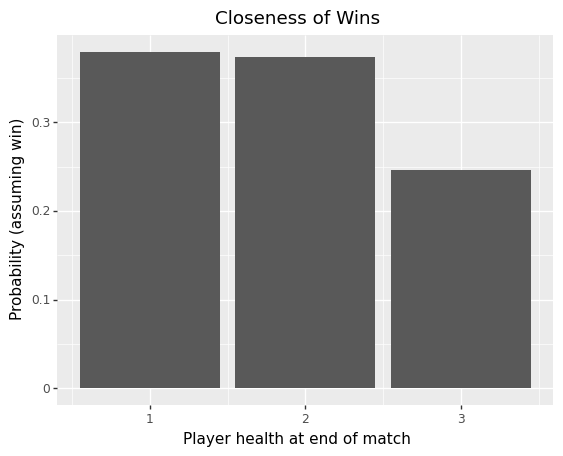

<ggplot: (8740641010007)>

In [12]:
wins = results[results["enemy_health"] == 0].copy()
wins["probability"] = wins["probability"] / sum(wins["probability"])

assert abs(sum(wins["probability"]) - 1.0) < 0.0000001

ggplot(wins, aes("player_health", "probability")) +\
    geom_col() +\
    ggtitle("Closeness of Wins") +\
    xlab("Player health at end of match") +\
    ylab("Probability (assuming win)")

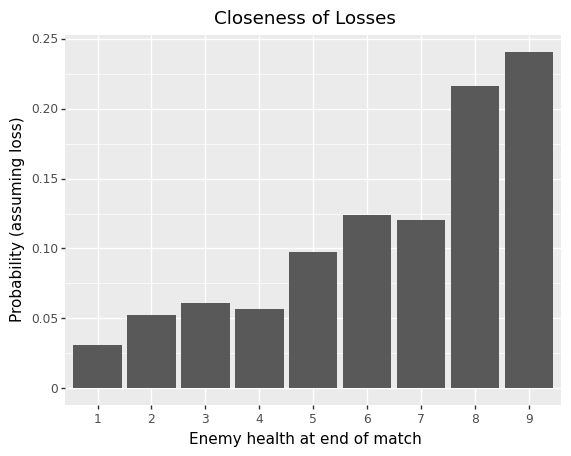

<ggplot: (8740640874947)>

In [13]:
losses = results[results["player_health"] == 0].copy()
losses["probability"] = losses["probability"] / sum(losses["probability"])

assert abs(sum(losses["probability"]) - 1.0) < 0.0000001

ggplot(losses, aes("enemy_health", "probability")) +\
    geom_col() +\
    ggtitle("Closeness of Losses") +\
    xlab("Enemy health at end of match") +\
    ylab("Probability (assuming loss)") +\
    scale_x_discrete(breaks=list(range(1, 10)), labels=[str(n) for n in range(1, 10)], limits=list(range(1, 10)))